# code_2_MFNN
* Author: Hugon Lee, and Heekyu Kim
* PI: Seunghwa Ryu
* References
	- https://doi.org/10.1016/j.jcp.2019.109020
	- 

# Prerequisite: PyTorch library

In [7]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import random_split

import pandas as pd

# Define multifidelity neural network

In [5]:
class Unit(nn.Module):
	def __init__(self, n_in, n_out):
		super(Unit, self).__init__()
		self.n_in = n_in
		self.n_out = n_out
		self.lin = nn.Linear(n_in, n_out)
		# self.act = nn.ReLU()
		self.act = nn.Tanh()
	def forward(self, x):
		x = self.lin(x)
		x = self.act(x)
		return x

class NN(nn.Module):
	def __init__(self, n_in, n_out, width, depth):
		super(NN, self).__init__()
		self.n_in = n_in
		self.n_out = n_out
		self.width = width

		self.stack = nn.ModuleList()
		self.stack.append(Unit(n_in, width))
		for i in range(depth):
			self.stack.append(Unit(width, width))
		self.stack.append(nn.Linear(width, n_out))
	def forward(self, x):
		for i in range(len(self.stack)):
			x = self.stack[i](x)
		return x

class NN_lin(nn.Module):
	def __init__(self, n_in, n_out, width, depth):
		super(NN_lin, self).__init__()
		self.n_in = n_in
		self.n_out = n_out
		self.width = width
		self.depth = depth

		self.stack = nn.ModuleList()
		self.stack.append(nn.Linear(n_in, width))
		for i in range(depth):
			self.stack.append(nn.Linear(width, width))
		self.stack.append(nn.Linear(width, n_out))
	def forward(self, x):
		for i in range(len(self.stack)):
			x = self.stack[i](x)
		return(x)

def weights_init(m):
	if isinstance(m, (nn.Conv2d, nn.Linear)):
		nn.init.xavier_normal_(m.weight)
		nn.init.constant_(m.bias, 0.0)

# Data

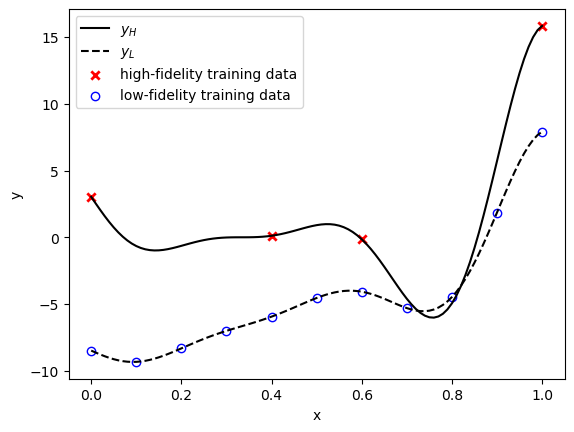

In [6]:
x = np.linspace(0, 1, 101).reshape(-1, 1) # input domain
y_hi = (6 * x - 2) ** 2 * np.sin(12 * x - 4) # true function
y_lo = 0.5 * (6 * x - 2) ** 2 * np.sin(12 * x - 4) + 10 * (x - 0.5) - 5 # true function

x_hi = np.array([0, 0.4, 0.6, 1]).reshape(-1, 1) # HF sample x
x_lo = np.linspace(0, 1, 11).reshape(-1, 1) # LF sample x
y_hi_star = (6 * x_hi - 2) ** 2 * np.sin(12 * x_hi - 4) # HF sample y
y_lo_star = 0.5 * (6 * x_lo - 2) ** 2 * np.sin(12 * x_lo - 4) + 10 * (x_lo - 0.5) - 5 # LF sample y
y_lo_star_prime = 10 + 6 * (6 * x_lo - 2) * np.sin(12 * x_lo - 4) + \
					0.5 * (6 * x_lo - 2) ** 2 * np.cos(12 * x_lo - 4) * 12 # LF sample y grad

fig, ax = plt.subplots()
ax.plot(x, y_hi, label='$y_H$', color='black')
ax.plot(x, y_lo, label='$y_L$', color='black', linestyle='dashed')
ax.scatter(x_hi, y_hi_star, color='red', linewidth=2, marker='x', label='high-fidelity training data')
ax.scatter(x_lo, y_lo_star, color='white', edgecolors='blue', marker='o', label='low-fidelity training data')
ax.set(xlabel='x', ylabel='y')
ax.legend()
plt.show()

# Single-fidelity HF prediction model

It:  0 Loss 63.00645446777344
It:  50 Loss 52.67666244506836
It:  100 Loss 45.896759033203125
It:  150 Loss 42.62504577636719
It:  200 Loss 41.126365661621094
It:  250 Loss 39.96308135986328
It:  300 Loss 38.66461181640625
It:  350 Loss 36.95063400268555
It:  400 Loss 33.63559341430664
It:  450 Loss 28.504043579101562
It:  500 Loss 23.47088050842285
It:  550 Loss 19.25695037841797
It:  600 Loss 15.845003128051758
It:  650 Loss 13.200410842895508
It:  700 Loss 11.071868896484375
It:  750 Loss 9.329808235168457
It:  800 Loss 7.89877986907959
It:  850 Loss 6.721645355224609
It:  900 Loss 5.752705097198486
It:  950 Loss 4.955183506011963
It:  1000 Loss 4.2993035316467285
It:  1050 Loss 3.760636329650879
It:  1100 Loss 3.318822145462036
It:  1150 Loss 2.956616163253784
It:  1200 Loss 2.659027099609375
It:  1250 Loss 2.41200852394104
It:  1300 Loss 2.1990020275115967
It:  1350 Loss 1.9874372482299805
It:  1400 Loss 1.6966931819915771
It:  1450 Loss 1.0859770774841309
It:  1500 Loss 0.3150038

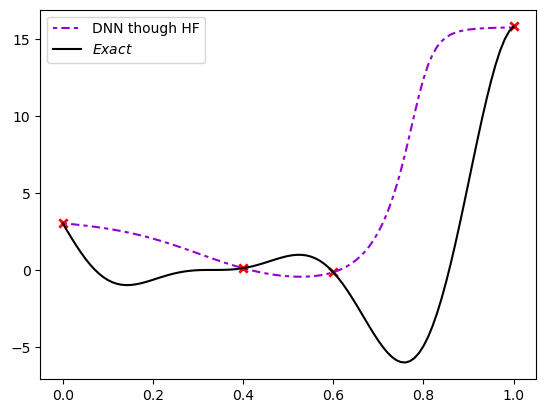

In [8]:
n_in = 1
n_out = 1
width = 10
depth = 2


## SF (HF) model
model_sfhf = NN(n_in, n_out, width, depth)
model_sfhf.apply(weights_init)
optimizer = optim.Adam(model_sfhf.parameters(), lr=0.001)
nIter = 2000
it = 0
loss_value = 1

while loss_value > 1e-3 or it < nIter:
	pred_sfhf = model_sfhf(torch.from_numpy(x_hi).float())
	loss = torch.mean(torch.square(pred_sfhf - torch.from_numpy(y_hi_star).float()))

	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	loss_value = loss.item()
	if it % 50 == 0:
		print('It: ', it, 'Loss', loss.item())
	it = it + 1

nn_pred_sfhf = model_sfhf(torch.from_numpy(x).float())


fig2, ax2 = plt.subplots()
line = ax2.plot(x, nn_pred_sfhf.detach().numpy(), label='DNN though HF', color='darkviolet')
line[0].set_dashes([2, 2, 4, 2])  # 2pt line, 2pt break, 4pt line, 2pt break
ax2.plot(x, y_hi, label='$Exact$', color='black')
ax2.scatter(x_hi, y_hi_star, marker='x', color='red', linewidth=2)
ax2.legend()
plt.show()


# Single-fidelity LF prediction model

It:  0 Loss 873.2673950195312
It:  50 Loss 727.6065673828125
It:  100 Loss 124.73556518554688
It:  150 Loss 113.2855453491211
It:  200 Loss 108.33101654052734
It:  250 Loss 105.94190216064453
It:  300 Loss 103.94815826416016
It:  350 Loss 102.36299896240234
It:  400 Loss 101.20343780517578
It:  450 Loss 100.36216735839844
It:  500 Loss 99.73747253417969
It:  550 Loss 99.26251983642578
It:  600 Loss 98.89572143554688
It:  650 Loss 98.60982513427734
It:  700 Loss 98.38561248779297
It:  750 Loss 100.28825378417969
It:  800 Loss 98.08781433105469
It:  850 Loss 97.97856140136719
It:  900 Loss 97.88912963867188
It:  950 Loss 97.90670013427734
It:  1000 Loss 97.76824188232422
It:  1050 Loss 97.7137222290039
It:  1100 Loss 98.02272033691406
It:  1150 Loss 97.65950775146484
It:  1200 Loss 97.6048812866211
It:  1250 Loss 97.57119750976562
It:  1300 Loss 100.35223388671875
It:  1350 Loss 97.53694915771484
It:  1400 Loss 97.50082397460938
It:  1450 Loss 97.47716522216797
It:  1500 Loss 98.14786529

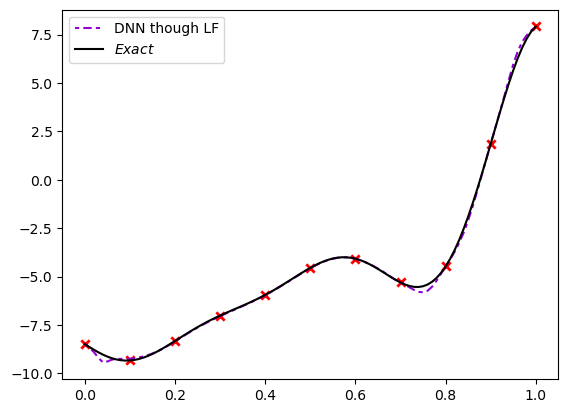

In [9]:
n_in = 1
n_out = 1
width = 20
depth = 4

## SF (LF) model
model_sflf = NN(n_in, n_out, width, depth)
model_sflf.apply(weights_init)
optimizer = optim.Adam(model_sflf.parameters(), lr=0.001)
nIter = 2000
it = 0
loss_value = 1

x_lo_r = torch.from_numpy(x_lo).float()
x_lo_r.requires_grad_()

while loss_value > 1e-3 or it < nIter:
	pred_sflf = model_sflf(x_lo_r)
	grads = autograd.grad(outputs=pred_sflf, inputs=x_lo_r,
		grad_outputs=torch.ones_like(pred_sflf), create_graph=True, retain_graph=True, only_inputs=True)[0]
	loss = torch.mean(torch.square(pred_sflf - torch.from_numpy(y_lo_star).float())) + \
		   torch.mean(torch.sum(torch.square(grads - torch.from_numpy(y_lo_star_prime).float()), 1, keepdim=True))

	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	loss_value = loss.item()
	if it % 50 == 0:
		print('It: ', it, 'Loss', loss.item())
	it = it + 1

nn_pred_sflf = model_sflf(torch.from_numpy(x).float())


fig3, ax3 = plt.subplots()
line = ax3.plot(x, nn_pred_sflf.detach().numpy(), label='DNN though LF', color='darkviolet')
line[0].set_dashes([2, 2, 4, 2])  # 2pt line, 2pt break, 4pt line, 2pt break
ax3.plot(x, y_lo, label='$Exact$', color='black')
ax3.scatter(x_lo, y_lo_star, marker='x', color='red', linewidth=2)
ax3.legend()
plt.show()

# Multi-fidelity HF prediction model
: build upon single-fidelity LF prediction model

It:  0 Loss 72.51699829101562
It:  50 Loss 36.336917877197266
It:  100 Loss 9.910606384277344
It:  150 Loss 6.363285541534424
It:  200 Loss 5.108414649963379
It:  250 Loss 4.556659698486328
It:  300 Loss 4.070359230041504
It:  350 Loss 3.6949431896209717
It:  400 Loss 3.3669471740722656
It:  450 Loss 3.1093645095825195
It:  500 Loss 2.8071813583374023
It:  550 Loss 2.5793795585632324
It:  600 Loss 2.3483054637908936
It:  650 Loss 2.387716293334961
It:  700 Loss 1.9158636331558228
It:  750 Loss 1.7014148235321045
It:  800 Loss 1.4781074523925781
It:  850 Loss 1.266286015510559
It:  900 Loss 1.1049290895462036
It:  950 Loss 0.9157148599624634
It:  1000 Loss 0.7907706499099731
It:  1050 Loss 0.6964473724365234
It:  1100 Loss 0.612167239189148
It:  1150 Loss 0.5570271611213684
It:  1200 Loss 0.4967109262943268
It:  1250 Loss 0.4487234950065613
It:  1300 Loss 0.4099941849708557
It:  1350 Loss 0.37520071864128113
It:  1400 Loss 0.34292125701904297
It:  1450 Loss 0.3126756548881531
It:  1500 

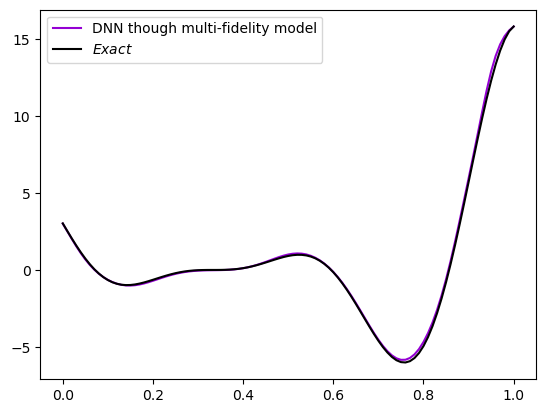

In [ ]:
alpha = torch.tensor([0.5], requires_grad=True)
model_cor_nli = NN(2, 1, 20, 4)
model_cor_nli.apply(weights_init)
model_cor_lin = NN_lin(2, 1, 10, 2)
model_cor_lin.apply(weights_init)

optimizer_mf = optim.Adam([{'params': model_cor_nli.parameters(), 'weight_decay': 0.01},
						   {'params': model_sflf.parameters(), 'weight_decay': 0.01},
						   {'params': model_cor_lin.parameters(), 'weight_decay': 0.01},
						   {'params': alpha, 'weight_decay': 0.01}],
						   lr = 1e-3)

nIter_mf = 10000
x_lo_r = torch.from_numpy(x_lo).float()
x_lo_r.requires_grad_()
loss_mf_value = 1
it = 0

while loss_mf_value > 1e-3 and it < nIter_mf:
	## LF NN
	pred_mflf = model_sflf(x_lo_r)
	grads = autograd.grad(outputs=pred_mflf, inputs=x_lo_r,
						  grad_outputs=torch.ones_like(pred_mflf),
						  create_graph=True, retain_graph=True, only_inputs=True)[0]
	loss_mflf = torch.mean(torch.square(pred_mflf - torch.from_numpy(y_lo_star).float())) + \
		        torch.mean(torch.sum(torch.square(grads - torch.from_numpy(y_lo_star_prime).float()), 1, keepdim=True))
	
	## LF prediction for HF x sample
	pred_mflf_2 = model_sflf(torch.from_numpy(x_hi).float())

	## Correlation NN
	pred_mf_cor = alpha * model_cor_nli(torch.cat((torch.from_numpy(x_hi).float(), pred_mflf_2), 1)) + \
		          (1-alpha) * model_cor_lin(torch.cat((torch.from_numpy(x_hi).float(), pred_mflf_2), 1))
	loss_mf_cor = torch.mean(torch.square(pred_mf_cor - torch.from_numpy(y_hi_star).float()))
	
	loss_mf = loss_mflf + loss_mf_cor
	
	optimizer_mf.zero_grad()
	loss_mf.backward()
	optimizer_mf.step()

	loss_mf_value = loss_mf.item()
	if it % 50 == 0:
		print('It: ', it, 'Loss', loss_mf.item())
	it = it + 1


nn_pred_mflf = model_sflf(torch.from_numpy(x).float())
nn_pred_mfhf = alpha * model_cor_nli(torch.cat((torch.from_numpy(x).float(), nn_pred_mflf), 1)) + \
	           (1 - alpha) * model_cor_lin(torch.cat((torch.from_numpy(x).float(), nn_pred_mflf), 1))
print('Alpha: ', alpha)


fig4, ax4 = plt.subplots()
ax4.plot(x, nn_pred_mfhf.detach().numpy(), label='DNN though multi-fidelity model', color='darkviolet')
ax4.plot(x, y_hi, label='$Exact$', color='black')
plt.legend()
plt.show()
